In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pulp
import sys
import os
import importlib.util
import importlib
import gurobipy as gp

# モジュールを強制的に再ロード（古いキャッシュをクリア）
if 'code' in sys.modules:
    del sys.modules['code']
# サブモジュールも削除
for module_name in list(sys.modules.keys()):
    if module_name.startswith('code.'):
        del sys.modules[module_name]

current_dir = os.getcwd()
spec = importlib.util.spec_from_file_location("code", os.path.join(current_dir, "code", "__init__.py"))
code_module = importlib.util.module_from_spec(spec)
sys.modules["code"] = code_module
spec.loader.exec_module(code_module)

# サブモジュールも再ロード
importlib.reload(code_module)

make_tensor_grid_2d = code_module.make_tensor_grid_2d
make_tensor_grid_3d = code_module.make_tensor_grid_3d
product_beta_density = code_module.product_beta_density
solve_mechanism_symmetry_2agents_with_synergy = code_module.solve_mechanism_symmetry_2agents_with_synergy
solve_mechanism_symmetry_2agents_with_synergy_iterative = code_module.solve_mechanism_symmetry_2agents_with_synergy_iterative
save_results_symmetry_2agents_with_synergy = code_module.save_results_symmetry_2agents_with_synergy
load_results_symmetry_2agents_with_synergy = code_module.load_results_symmetry_2agents_with_synergy

print("モジュールを再ロードしました")


モジュールを再ロードしました


In [2]:
home_license = os.path.expanduser('~/gurobi.lic')
os.environ['GRB_LICENSE_FILE'] = home_license

SOLVER = pulp.GUROBI(msg=True)


# ケース1


In [3]:
# ケース1: 財a, 財b, シナジーαはBeta(1,1)
# 対称性制約のため、参加者1と参加者2は同じpointsとweightsを使用
NX, NY, NZ = 25, 25, 25
BETA_PARAMS = [
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
]

points1, weights1 = make_tensor_grid_3d(NX, NY, NZ, BETA_PARAMS)
points2, weights2 = points1.copy(), weights1.copy()

In [4]:
status, obj_val, u1_sol, u2_sol, p1_sol, p2_sol, n_iter = solve_mechanism_symmetry_2agents_with_synergy_iterative(
    points1, weights1, (NX, NY, NZ),
    solver=SOLVER
)

print("LP status:", status)
print("Optimal revenue:", obj_val)
print(f"Number of iterations: {n_iter}")

# 結果を保存
filepath_case1 = save_results_symmetry_2agents_with_synergy(
    points1, weights1,
    u1_sol, u2_sol, p1_sol, p2_sol,
    obj_val, status,
    grid_sizes1=(NX, NY, NZ),
    n_iter=n_iter,
    filename="results_symmetry_synergy_case1.npz"
)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2749041
Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 136875 rows, 62500 columns and 379375 nonzeros (Max)
Model fingerprint: 0x644e4a85
Model has 62500 linear objective coefficients
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [3e-06, 1e-04]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve removed 18125 rows and 1299 columns
Presolve time: 0.12s
Presolved: 118750 rows, 61201 columns, 336691 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Orderi

Loaded data: J1=125, obj_val=0.9616000000000007
Grid sizes: (np.int32(5), np.int32(5), np.int32(5))
Number of iterations: 1


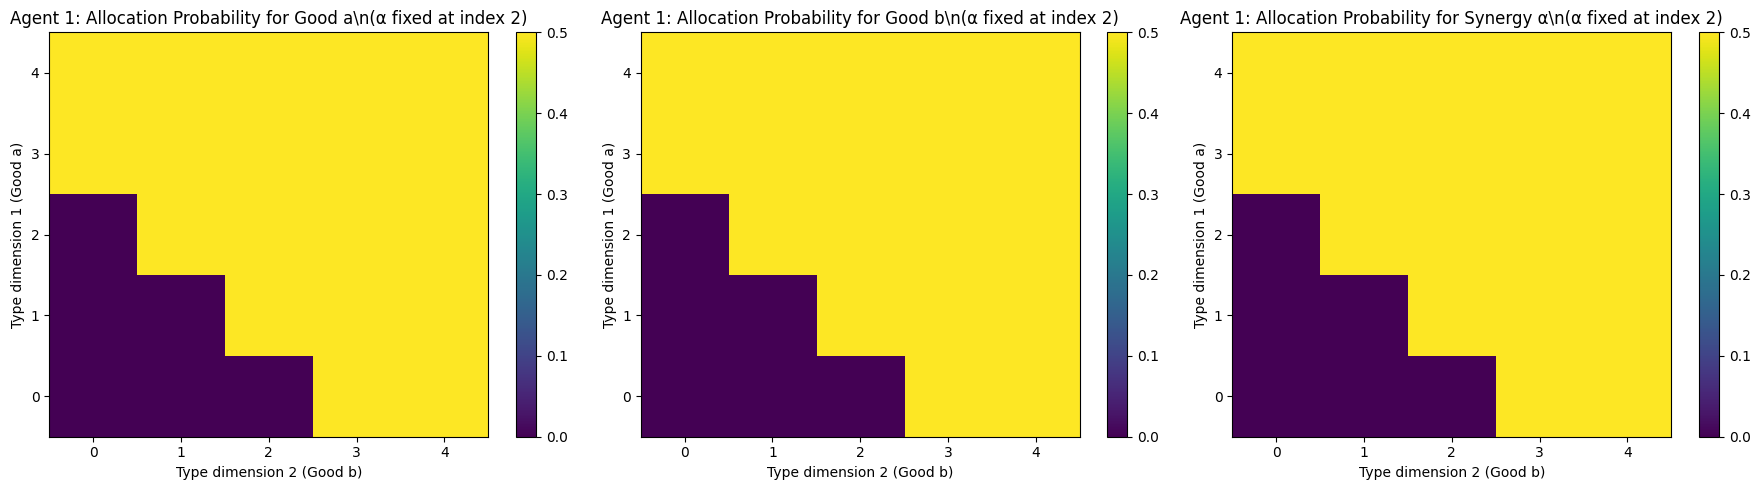

In [5]:
# ケース1の可視化: エージェント1の配分確率（財a, 財b, シナジーα）
# 対称性により、u1のみの設計なので、エージェント1の型空間のみを可視化
# シナジーαの値を固定して、エージェント1の型空間（財a, 財b）を2Dスライスとして可視化

# 保存されたデータから読み込む
data = load_results_symmetry_2agents_with_synergy("data/results_symmetry_synergy_case1.npz")
print(f"Loaded data: J1={data['J1']}, obj_val={data['obj_val']}")
print(f"Grid sizes: {data.get('grid_sizes1', 'N/A')}")
print(f"Number of iterations: {data.get('n_iter', 'N/A')}")

# シナジーαのインデックスを固定（中央値）
alpha_idx = NZ // 2

# エージェント1の型空間を3Dグリッドに再構成
NX1, NY1, NZ1 = data['grid_sizes1']
# 対称性により、p1_solの形状は (3, J1) に変更
p1_a_slice = data['p1_sol'][0, :]  # 財aの配分確率
p1_b_slice = data['p1_sol'][1, :]  # 財bの配分確率
p1_alpha_slice = data['p1_sol'][2, :]  # シナジーαの配分確率

# 3Dグリッドに再構成
p1_a_3d = p1_a_slice.reshape(NX1, NY1, NZ1)
p1_b_3d = p1_b_slice.reshape(NX1, NY1, NZ1)
p1_alpha_3d = p1_alpha_slice.reshape(NX1, NY1, NZ1)

# シナジーαの値を固定して2Dスライスを取得
p1_a_2d = p1_a_3d[:, :, alpha_idx]
p1_b_2d = p1_b_3d[:, :, alpha_idx]
p1_alpha_2d = p1_alpha_3d[:, :, alpha_idx]

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 財aの配分確率
im1 = axes[0].imshow(p1_a_2d, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\\n(α fixed at index {alpha_idx})')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p1_b_2d, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 1: Allocation Probability for Good b\\n(α fixed at index {alpha_idx})')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

# シナジーαの配分確率
im3 = axes[2].imshow(p1_alpha_2d, origin='lower', aspect='auto', cmap='viridis')
axes[2].set_title(f'Agent 1: Allocation Probability for Synergy α\\n(α fixed at index {alpha_idx})')
axes[2].set_xlabel('Type dimension 2 (Good b)')
axes[2].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()


# ケース2


In [10]:
# 財a, 財bはBeta(1,1)、シナジーαはU[-1,0]
NX2, NY2, NZ2 = 5, 5, 5
BETA_PARAMS_MIXED = [
    {'type': 'beta', 'params': (1.0, 1.0), 'range': (0, 1)},
    {'type': 'beta', 'params': (1.0, 1.0), 'range': (0, 1)},
    {'type': 'uniform', 'range': (-1, 0)},
]

points1_2, weights1_2 = make_tensor_grid_3d(NX2, NY2, NZ2, BETA_PARAMS_MIXED)
points2_2, weights2_2 = points1_2.copy(), weights1_2.copy()

print(f"#types agent1 = {len(points1_2)}")
print(f"#types agent2 = {len(points2_2)}")
print(f"Total type combinations = {len(points1_2) * len(points2_2)}")
print(f"ex. first point agent1, weight = {points1_2[0]}, {weights1_2[0]}")
print(f"ex. first point agent2, weight = {points2_2[0]}, {weights2_2[0]}")


#types agent1 = 125
#types agent2 = 125
Total type combinations = 15625
ex. first point agent1, weight = (0.1, 0.1, -0.9), 0.007999999999999998
ex. first point agent2, weight = (0.1, 0.1, -0.9), 0.007999999999999998


In [ ]:
status2, obj_val2, u1_sol2, u2_sol2, p1_sol2, p2_sol2, n_iter2 = solve_mechanism_symmetry_2agents_with_synergy_iterative(
    points1_2, weights1_2, (NX2, NY2, NZ2),
    solver=SOLVER
)

print("LP status:", status2)
print("Optimal revenue:", obj_val2)
print(f"Number of iterations: {n_iter2}")

# 結果を保存（対称性により、points2とweights2は自動的にpoints1とweights1から設定される）
filepath_case2 = save_results_symmetry_2agents_with_synergy(
    points1_2, weights1_2,
    u1_sol2, u2_sol2, p1_sol2, p2_sol2,
    obj_val2, status2,
    grid_sizes1=(NX2, NY2, NZ2),
    n_iter=n_iter2,
    filename="results_symmetry_synergy_case2.npz"
)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2749041
Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 121875 rows, 62500 columns and 334375 nonzeros (Max)
Model fingerprint: 0x46fd5dfe
Model has 31500 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e-05, 3e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4737 rows and 2392 columns
Presolve time: 0.31s
Presolved: 117138 rows, 60108 columns, 327856 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Orderin

Loaded data: J1=125, J2=125, obj_val=0.820083200000044
Grid sizes: (np.int32(5), np.int32(5), np.int32(5)), (np.int32(5), np.int32(5), np.int32(5))
Number of iterations: 5


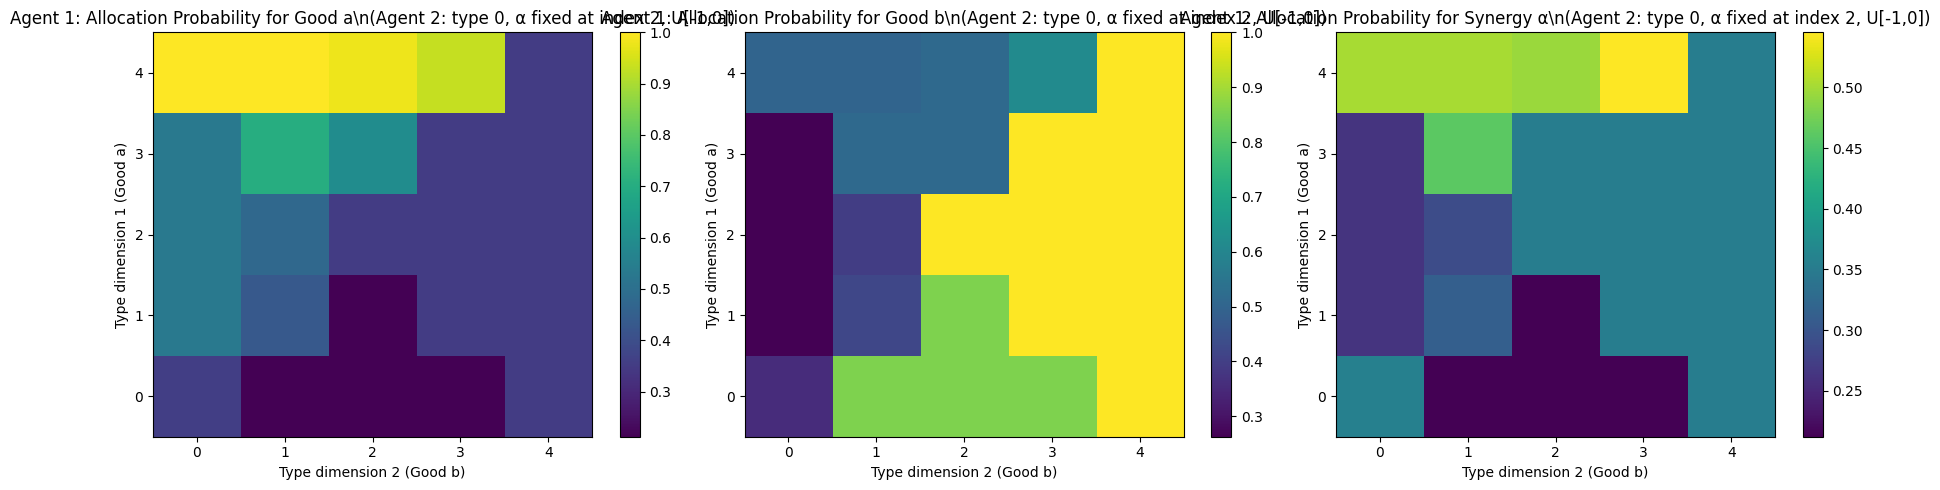

In [ ]:
# ケース2の可視化: エージェント1の配分確率（財a, 財b, シナジーα）
# 対称性により、u1のみの設計なので、エージェント1の型空間のみを可視化
# シナジーαの値を固定して、エージェント1の型空間（財a, 財b）を2Dスライスとして可視化

# 保存されたデータから読み込む
data2 = load_results_symmetry_2agents_with_synergy("data/results_symmetry_synergy_case2.npz")
print(f"Loaded data: J1={data2['J1']}, obj_val={data2['obj_val']}")
print(f"Grid sizes: {data2.get('grid_sizes1', 'N/A')}")
print(f"Number of iterations: {data2.get('n_iter', 'N/A')}")

# シナジーαのインデックスを固定（中央値）
alpha_idx = NZ2 // 2

# エージェント1の型空間を3Dグリッドに再構成
NX1_2, NY1_2, NZ1_2 = data2['grid_sizes1']
# 対称性により、p1_solの形状は (3, J1) に変更
p1_a_slice2 = data2['p1_sol'][0, :]  # 財aの配分確率
p1_b_slice2 = data2['p1_sol'][1, :]  # 財bの配分確率
p1_alpha_slice2 = data2['p1_sol'][2, :]  # シナジーαの配分確率

# 3Dグリッドに再構成
p1_a_3d_2 = p1_a_slice2.reshape(NX1_2, NY1_2, NZ1_2)
p1_b_3d_2 = p1_b_slice2.reshape(NX1_2, NY1_2, NZ1_2)
p1_alpha_3d_2 = p1_alpha_slice2.reshape(NX1_2, NY1_2, NZ1_2)

# シナジーαの値を固定して2Dスライスを取得
p1_a_2d_2 = p1_a_3d_2[:, :, alpha_idx]
p1_b_2d_2 = p1_b_3d_2[:, :, alpha_idx]
p1_alpha_2d_2 = p1_alpha_3d_2[:, :, alpha_idx]

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 財aの配分確率
im1 = axes[0].imshow(p1_a_2d_2, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\\n(α fixed at index {alpha_idx}, U[-1,0])')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p1_b_2d_2, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 1: Allocation Probability for Good b\\n(α fixed at index {alpha_idx}, U[-1,0])')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

# シナジーαの配分確率
im3 = axes[2].imshow(p1_alpha_2d_2, origin='lower', aspect='auto', cmap='viridis')
axes[2].set_title(f'Agent 1: Allocation Probability for Synergy α\\n(α fixed at index {alpha_idx}, U[-1,0])')
axes[2].set_xlabel('Type dimension 2 (Good b)')
axes[2].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()


# ケース3


In [12]:
# 財a, 財bはBeta(1,1)、シナジーαはU[-1,1]
NX3, NY3, NZ3 = 5, 5, 10
BETA_PARAMS_MIXED3 = [
    {'type': 'beta', 'params': (1.0, 1.0), 'range': (0, 1)},
    {'type': 'beta', 'params': (1.0, 1.0), 'range': (0, 1)},
    {'type': 'uniform', 'range': (-1, 1)},
]

points1_3, weights1_3 = make_tensor_grid_3d(NX3, NY3, NZ3, BETA_PARAMS_MIXED3)
points2_3, weights2_3 = points1_3.copy(), weights1_3.copy()

print(f"#types agent1 = {len(points1_3)}")
print(f"#types agent2 = {len(points2_3)}")
print(f"Total type combinations = {len(points1_3) * len(points2_3)}")
print(f"ex. first point agent1, weight = {points1_3[0]}, {weights1_3[0]}")


#types agent1 = 250
#types agent2 = 250
Total type combinations = 62500
ex. first point agent1, weight = (0.1, 0.1, -0.9), 0.003999999999999999


In [ ]:
status3, obj_val3, u1_sol3, u2_sol3, p1_sol3, p2_sol3, n_iter3 = solve_mechanism_symmetry_2agents_with_synergy_iterative(
    points1_3, weights1_3, (NX3, NY3, NZ3),
    solver=SOLVER
)

print("LP status:", status3)
print("Optimal revenue:", obj_val3)
print(f"Number of iterations: {n_iter3}")

# 結果を保存（対称性により、points2とweights2は自動的にpoints1とweights1から設定される）
filepath_case3 = save_results_symmetry_2agents_with_synergy(
    points1_3, weights1_3,
    u1_sol3, u2_sol3, p1_sol3, p2_sol3,
    obj_val3, status3,
    grid_sizes1=(NX3, NY3, NZ3),
    n_iter=n_iter3,
    filename="results_symmetry_synergy_case3.npz"
)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2749041
Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 500000 rows, 250000 columns and 1375000 nonzeros (Max)
Model fingerprint: 0x698ff7ea
Model has 122375 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [4e-21, 6e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17197 rows and 9282 columns
Presolve time: 0.54s
Presolved: 482803 rows, 240718 columns, 1342041 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

O

Loaded data: J1=250, J2=250, obj_val=1.1620789333331716
Grid sizes: (np.int32(5), np.int32(5), np.int32(10)), (np.int32(5), np.int32(5), np.int32(10))
Number of iterations: 6


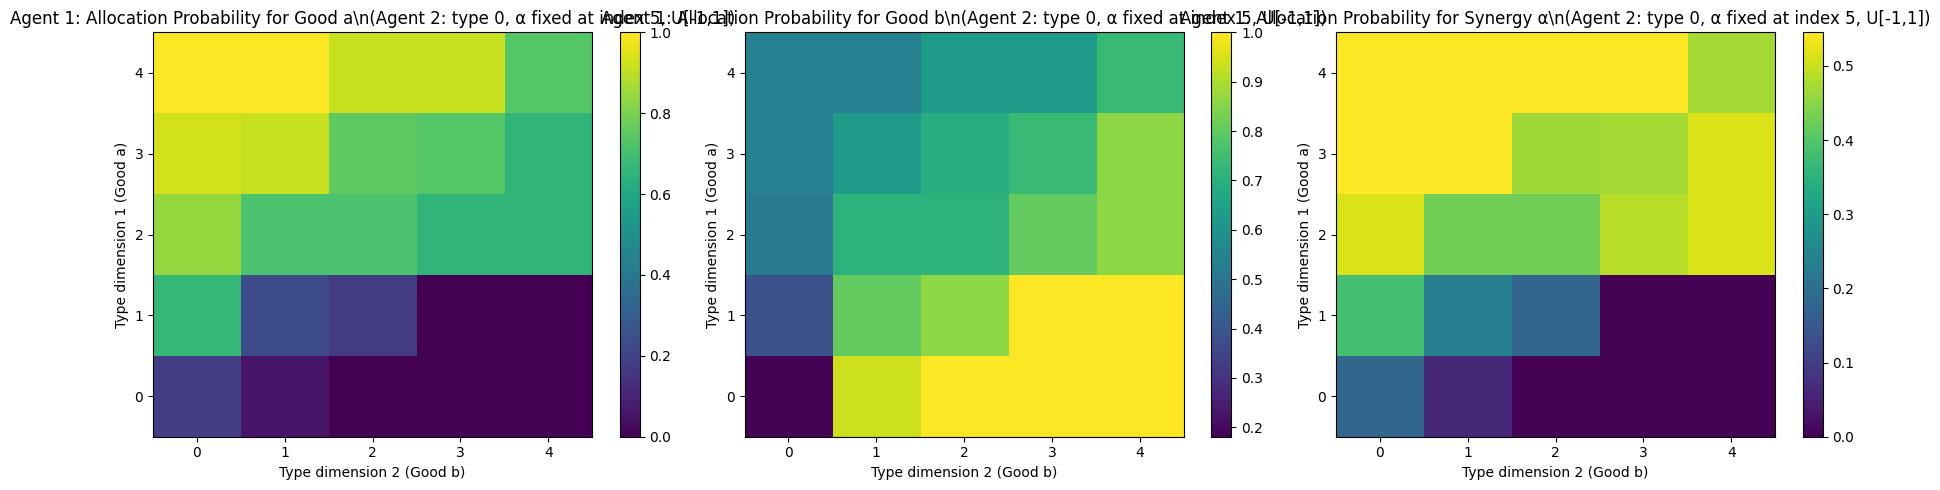

In [ ]:
# ケース3の可視化: エージェント1の配分確率（財a, 財b, シナジーα）
# 対称性により、u1のみの設計なので、エージェント1の型空間のみを可視化
# シナジーαの値を固定して、エージェント1の型空間（財a, 財b）を2Dスライスとして可視化

# 保存されたデータから読み込む
data3 = load_results_symmetry_2agents_with_synergy("data/results_symmetry_synergy_case3.npz")
print(f"Loaded data: J1={data3['J1']}, obj_val={data3['obj_val']}")
print(f"Grid sizes: {data3.get('grid_sizes1', 'N/A')}")
print(f"Number of iterations: {data3.get('n_iter', 'N/A')}")

# シナジーαのインデックスを固定（中央値）
alpha_idx = NZ3 // 2

# エージェント1の型空間を3Dグリッドに再構成
NX1_3, NY1_3, NZ1_3 = data3['grid_sizes1']
# 対称性により、p1_solの形状は (3, J1) に変更
p1_a_slice3 = data3['p1_sol'][0, :]  # 財aの配分確率
p1_b_slice3 = data3['p1_sol'][1, :]  # 財bの配分確率
p1_alpha_slice3 = data3['p1_sol'][2, :]  # シナジーαの配分確率

# 3Dグリッドに再構成
p1_a_3d_3 = p1_a_slice3.reshape(NX1_3, NY1_3, NZ1_3)
p1_b_3d_3 = p1_b_slice3.reshape(NX1_3, NY1_3, NZ1_3)
p1_alpha_3d_3 = p1_alpha_slice3.reshape(NX1_3, NY1_3, NZ1_3)

# シナジーαの値を固定して2Dスライスを取得
p1_a_2d_3 = p1_a_3d_3[:, :, alpha_idx]
p1_b_2d_3 = p1_b_3d_3[:, :, alpha_idx]
p1_alpha_2d_3 = p1_alpha_3d_3[:, :, alpha_idx]

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 財aの配分確率
im1 = axes[0].imshow(p1_a_2d_3, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title(f'Agent 1: Allocation Probability for Good a\\n(α fixed at index {alpha_idx}, U[-1,1])')
axes[0].set_xlabel('Type dimension 2 (Good b)')
axes[0].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im1, ax=axes[0])

# 財bの配分確率
im2 = axes[1].imshow(p1_b_2d_3, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title(f'Agent 1: Allocation Probability for Good b\\n(α fixed at index {alpha_idx}, U[-1,1])')
axes[1].set_xlabel('Type dimension 2 (Good b)')
axes[1].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im2, ax=axes[1])

# シナジーαの配分確率
im3 = axes[2].imshow(p1_alpha_2d_3, origin='lower', aspect='auto', cmap='viridis')
axes[2].set_title(f'Agent 1: Allocation Probability for Synergy α\\n(α fixed at index {alpha_idx}, U[-1,1])')
axes[2].set_xlabel('Type dimension 2 (Good b)')
axes[2].set_ylabel('Type dimension 1 (Good a)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()
